# Project 11 - Video game sales regression

# Step 1 - Loading libraries

In [24]:
import pandas as pd
from torch import nn, optim
import torch.nn.functional as F
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Step 2 - Database

In [2]:
torch.manual_seed(123)

In [4]:
df = pd.read_csv('Datasets/games.csv')
df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.shape

(16719, 16)

In [6]:
df = df.drop(columns=['Other_Sales', 'Global_Sales', 'Developer'], axis=1)

In [7]:
df.shape

(16719, 13)

<Axes: >

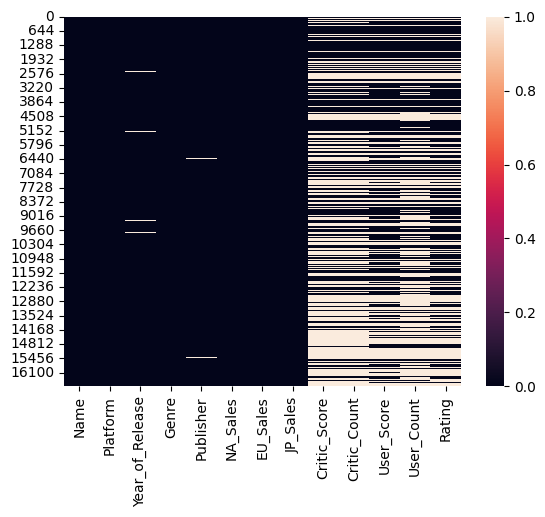

In [8]:
sns.heatmap(df.isnull())

In [9]:
df = df.dropna(axis=0)

<Axes: >

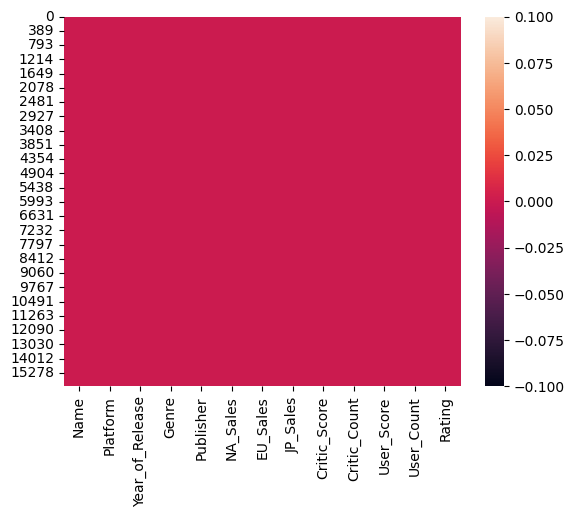

In [10]:
sns.heatmap(df.isnull())

In [11]:
df.shape

(6825, 13)

In [16]:
df.loc[(df['NA_Sales'] <=0) | (df['EU_Sales'] <=0) | (df['JP_Sales'] <=0)]

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
61,Just Dance 3,Wii,2011.0,Misc,Ubisoft,5.95,3.11,0.0,74.0,15.0,7.8,16.0,E10+
85,The Sims 3,PC,2009.0,Simulation,Electronic Arts,0.99,6.42,0.0,86.0,75.0,7.6,886.0,T
100,Call of Duty: World at War,X360,2008.0,Shooter,Activision,4.81,1.88,0.0,84.0,84.0,7.6,580.0,M
103,Just Dance,Wii,2009.0,Misc,Ubisoft,3.48,2.99,0.0,49.0,21.0,8,110.0,E10+
116,Just Dance 4,Wii,2012.0,Misc,Ubisoft,4.05,2.16,0.0,74.0,10.0,7.3,28.0,E10+
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16667,E.T. The Extra-Terrestrial,GBA,2001.0,Action,NewKidCo,0.01,0.00,0.0,46.0,4.0,2.4,21.0,E
16677,Mortal Kombat: Deadly Alliance,GBA,2002.0,Fighting,Midway Games,0.01,0.00,0.0,81.0,12.0,8.8,9.0,M
16696,Metal Gear Solid V: Ground Zeroes,PC,2014.0,Action,Konami Digital Entertainment,0.00,0.01,0.0,80.0,20.0,7.6,412.0,M
16700,Breach,PC,2011.0,Shooter,Destineer,0.01,0.00,0.0,61.0,12.0,5.8,43.0,T


In [17]:
df = df.drop(df.loc[(df['NA_Sales'] <=0) | (df['EU_Sales'] <=0) | (df['JP_Sales'] <=0)].index)

In [18]:
df.shape

(1720, 13)

In [19]:
df = df.drop(columns=['Name'], axis=1)

In [20]:
df.shape

(1720, 12)

In [21]:
forecasters = df.iloc[:, [0,1,2,3,7,8,9,10,11]].values
forecasters

array([['Wii', 2006.0, 'Sports', ..., '8', 322.0, 'E'],
       ['Wii', 2008.0, 'Racing', ..., '8.3', 709.0, 'E'],
       ['Wii', 2009.0, 'Sports', ..., '8', 192.0, 'E'],
       ...,
       ['PS2', 2007.0, 'Strategy', ..., '7.9', 17.0, 'E10+'],
       ['Wii', 2006.0, 'Simulation', ..., '4.9', 8.0, 'E'],
       ['PSP', 2007.0, 'Sports', ..., '6.3', 4.0, 'E']], dtype=object)

In [22]:
sales = df.iloc[:, 4:7].values
sales

array([[4.136e+01, 2.896e+01, 3.770e+00],
       [1.568e+01, 1.276e+01, 3.790e+00],
       [1.561e+01, 1.093e+01, 3.280e+00],
       ...,
       [1.000e-02, 1.000e-02, 3.000e-02],
       [3.000e-02, 1.000e-02, 1.000e-02],
       [1.000e-02, 1.000e-02, 1.000e-02]])

In [27]:
onehotencoder = ColumnTransformer(transformers=[("OneHot", OneHotEncoder(), [0,2,3,8])], remainder='passthrough')

forecasters = onehotencoder.fit_transform(forecasters).toarray()

In [29]:
forecasters.shape

(1720, 130)

# Step 3 - Model building

In [30]:
class torchregressor(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.dense0 = nn.Linear(130, 67)
        self.dense1 = nn.Linear(67, 67)

        self.activation = nn.Sigmoid()

        self.output = nn.Linear(67, 3)
    
    def forward(self, X):
        X = self.dense0(X)
        X = self.activation(X)

        X = self.dense1(X)
        X = self.activation(X)

        X = self.output(X)
        return X

In [42]:
regressor = torchregressor()
optimizer = optim.Adam(regressor.parameters())
criterion = nn.MSELoss()

In [33]:
type(forecasters)

numpy.ndarray

In [35]:
forecasters = torch.tensor(forecasters, dtype=torch.float32)
sales = torch.tensor(sales, dtype=torch.float32)

/tmp/ipykernel_7996/1883870622.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  forecasters = torch.tensor(forecasters, dtype=torch.float32)


In [36]:
type(forecasters)

torch.Tensor

In [38]:
dataset = torch.utils.data.TensorDataset(forecasters, sales)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)

# Step 4 - Model training

In [39]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [44]:
regressor.to(device)

torchregressor(
  (dense0): Linear(in_features=130, out_features=67, bias=True)
  (dense1): Linear(in_features=67, out_features=67, bias=True)
  (activation): Sigmoid()
  (output): Linear(in_features=67, out_features=3, bias=True)
)

In [45]:
for epoch in range(1000):
    running_loss = 0.
    running_mse_0 = 0.
    running_mse_1 = 0.
    running_mse_2 = 0.

    for i, data in enumerate(train_loader):
        inputs, labels = data

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = regressor.forward(inputs)

        mse_0 = F.mse_loss(outputs[:, 0], labels[:,0]).item()
        mse_1 = F.mse_loss(outputs[:, 1], labels[:,1]).item()
        mse_2 = F.mse_loss(outputs[:, 2], labels[:,2]).item()

        running_mse_0 += mse_0 * len(inputs)
        running_mse_1 += mse_1 * len(inputs)
        running_mse_2 += mse_2 * len(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss = loss.item()
        running_loss += loss * len(inputs)

        print('\rEpoch: {:4d} - Loop: {:3d} of {:3d}: error_0: {:6.4f} | error_1 \ {:6.4f} | error_2 \ {:6.4f} - cost {:6.4f}'.format(
            epoch+1, i+1, len(train_loader), mse_0, mse_1, mse_2, loss
        ), end='\r')

    print('Epoch: {:4d} Done: error_0 {:6.4f} | error_1 {:6.4f} | error_2 {:6.4f} - cost {:6.4f}'.format(
        epoch+1, running_mse_0/len(dataset), running_mse_1/len(dataset), running_mse_2/len(dataset), running_loss/len(dataset)
    ))
    

Epoch:    1 Done: error_0 2.8942 | error_1 1.4659 | error_2 0.2826 - cost 1.5475.0426 - cost 0.24534663
Epoch:    2 Done: error_0 2.6945 | error_1 1.3817 | error_2 0.2783 - cost 1.4515.0770 - cost 1.29039843
Epoch:    3 Done: error_0 2.6517 | error_1 1.3736 | error_2 0.2806 - cost 1.4353.0343 - cost 0.17366890
Epoch:    4 Done: error_0 2.6416 | error_1 1.3652 | error_2 0.2810 - cost 1.4293.3540 - cost 0.44114711
Epoch:    5 Done: error_0 2.6150 | error_1 1.3592 | error_2 0.2801 - cost 1.4181.0730 - cost 0.36770835
Epoch:    6 Done: error_0 2.6056 | error_1 1.3524 | error_2 0.2812 - cost 1.4131.0968 - cost 0.17383641
Epoch:    7 Done: error_0 2.6464 | error_1 1.3665 | error_2 0.2796 - cost 1.4308.1035 - cost 0.17766557
Epoch:    8 Done: error_0 2.6513 | error_1 1.3675 | error_2 0.2814 - cost 1.4334.0335 - cost 0.19420254
Epoch:    9 Done: error_0 2.6358 | error_1 1.3556 | error_2 0.2795 - cost 1.4237.2596 - cost 0.44703142
Epoch:   10 Done: error_0 2.6324 | error_1 1.3646 | error_2 0.28

# Step - 5: Model evaluation

In [46]:
regressor.eval()

torchregressor(
  (dense0): Linear(in_features=130, out_features=67, bias=True)
  (dense1): Linear(in_features=67, out_features=67, bias=True)
  (activation): Sigmoid()
  (output): Linear(in_features=67, out_features=3, bias=True)
)

In [47]:
forecasters = forecasters.to(device)
forecastings = regressor.forward(forecasters)

In [48]:
forecastings

tensor([[0.6261, 0.4266, 0.2276],
        [0.6261, 0.4266, 0.2276],
        [0.6261, 0.4266, 0.2276],
        ...,
        [0.6261, 0.4266, 0.2276],
        [0.6261, 0.4266, 0.2276],
        [0.6261, 0.4266, 0.2276]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [49]:
forecastings = forecastings.cpu().detach().numpy()

forecastings.mean(axis=0)

array([0.8020298, 0.5417691, 0.2326985], dtype=float32)

In [50]:
sales.mean(axis=0)

tensor([0.8541, 0.5804, 0.2355])

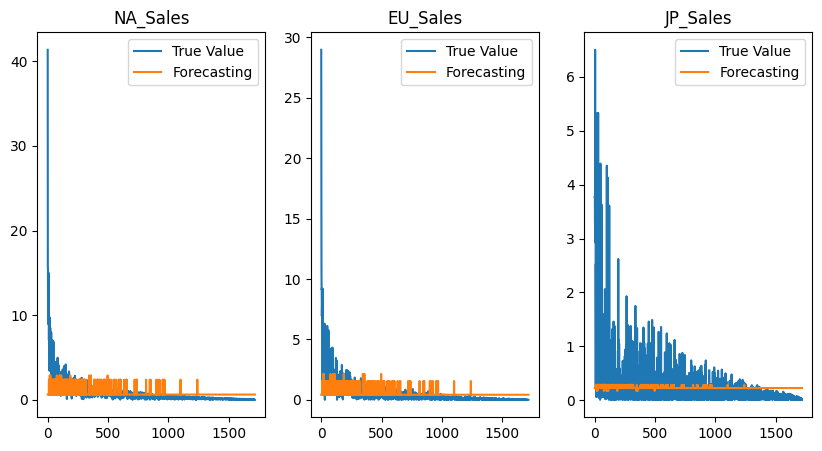

In [52]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

for i in range(3):
    ax[i].plot(sales[:, i])
    ax[i].plot(forecastings[:, i])
    ax[i].legend(['True Value', 'Forecasting'])
    ax[i].set_title(df.columns[4+i])

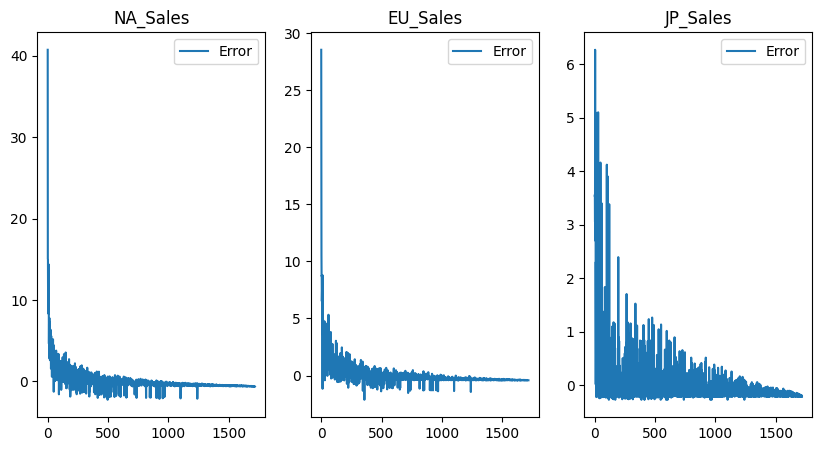

In [54]:
sales_array = sales.numpy()

fig, ax = plt.subplots(1,3, figsize=(10,5))
for i in range(3):
    ax[i].plot(sales_array[:, i] - forecastings[:, i])
    ax[i].legend(['Error'])
    ax[i].set_title(df.columns[4+i])

plt.show()

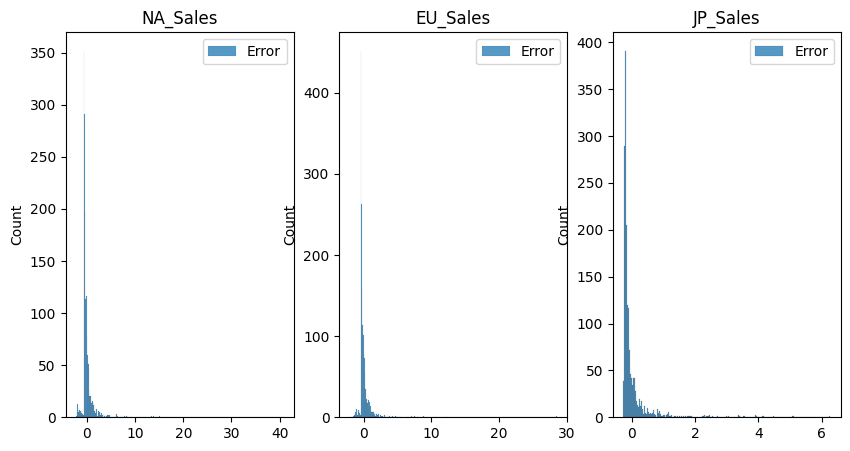

In [59]:
# distribution of errors

fig, ax = plt.subplots(1,3, figsize=(10,5))
for i in range(3):
    sns.histplot(sales_array[:, i] - forecastings[:, i], ax=ax[i])
    ax[i].set_title(df.columns[4+i])
    ax[i].legend(['Error'])